In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from read_dataset import read_ceps1d_with_train_test
from read_saved_models import loadMfcc1dStanderdScaler

Using TensorFlow backend.


In [2]:
def getStanderizedData(data):
    data_shape = data.shape
    n = data_shape[0]
    reshaped_data = data.reshape(n, -1)
    saved_ss = loadMfcc1dStanderdScaler()
    trasformed_data = saved_ss.transform(reshaped_data)
    ret_data = trasformed_data.reshape(data_shape)
    return ret_data

In [5]:
X_train, X_test, y_train, y_test = read_ceps1d_with_train_test(recreate_data=True)

In [6]:
X_ss_train= getStanderizedData(X_train)
X_ss_test= getStanderizedData(X_test)

In [7]:
print(X_ss_train.shape)
print(X_ss_test.shape)
print(y_train.shape)
print(y_test.shape)

(600, 1, 30, 1293)
(400, 1, 30, 1293)
(600, 10)
(400, 10)


In [8]:
model = Sequential()

# the model is convolutional with layer of 30 * 1293
model.add(Conv2D(500, (10, 10), activation='relu',
                 input_shape=(1, 30, 1293),
                 data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(100, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
    
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', 'categorical_accuracy'])

In [9]:
result = model.fit(X_ss_train, y_train, batch_size=30, epochs=10, validation_split=0.2)

Train on 480 samples, validate on 120 samples
Epoch 1/10
480/480 [==============================] - 928s - loss: 2.6328 - acc: 0.1854 - categorical_accuracy: 0.1854 - val_loss: 13.1475 - val_acc: 0.1333 - val_categorical_accuracy: 0.1333
Epoch 2/10
480/480 [==============================] - 896s - loss: 2.1102 - acc: 0.2667 - categorical_accuracy: 0.2667 - val_loss: 11.7781 - val_acc: 0.1417 - val_categorical_accuracy: 0.1417
Epoch 3/10
480/480 [==============================] - 886s - loss: 1.7851 - acc: 0.3813 - categorical_accuracy: 0.3813 - val_loss: 10.6183 - val_acc: 0.1333 - val_categorical_accuracy: 0.1333
Epoch 4/10
480/480 [==============================] - 928s - loss: 1.6574 - acc: 0.4229 - categorical_accuracy: 0.4229 - val_loss: 7.0853 - val_acc: 0.2333 - val_categorical_accuracy: 0.2333
Epoch 5/10
480/480 [==============================] - 922s - loss: 1.4988 - acc: 0.4771 - categorical_accuracy: 0.4771 - val_loss: 5.4496 - val_acc: 0.2250 - val_categorical_accuracy: 0.2

In [10]:
score = model.evaluate(X_ss_test, y_test, batch_size=30)
print(model.metrics_names)
print(score)

400/400 [==============================] - 425s    
['loss', 'acc', 'categorical_accuracy']
[1.6650218188762664, 0.46000001095235349, 0.46000001095235349]


In [11]:
model_filepath = "./savedModels/ceps_cnn1d_model.h5"
model.save(model_filepath)

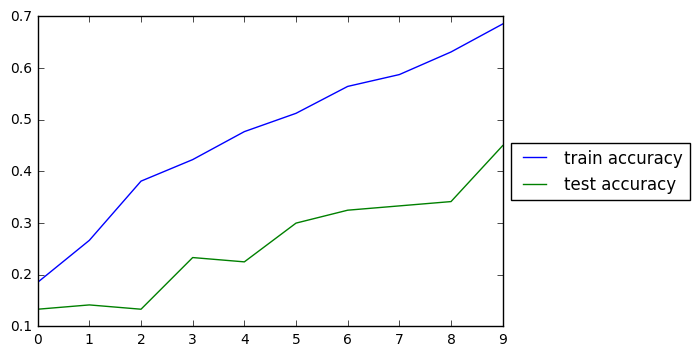

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(range(10), result.history['acc'], label='train accuracy')
plt.plot(range(10), result.history['val_acc'], label='test accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
